# Load Libraries

In [36]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, NMF
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Import SVV Connection

In [37]:
import psycopg2

def get_svv_connection():
    con=psycopg2.connect(dbname= 'svv', host='svv-rs-prod-bi.cjddijbnvfpr.eu-west-1.redshift.amazonaws.com', \
                         port= 5439, user= 'annieb', password= '3wMfPYCVwpscSzau')
    
    return con

# Connect to SVV and get relevant tables

In [38]:
query_data_1 = "Select * from sandbox.genre_consumption_proportions_hubplus_segmentation_AB"
query_data_2 = "Select * from sandbox.subgenre_consumption_proportions_hubplus_segmentation_AB"
query_data_3 = "Select * from sandbox.viewers_hubplus_segmentation_AB"
query_data_4 = "Select * from sandbox.programme_proportions_hubplus_segmentation_AB"
query_data_5 = "Select * from sandbox.viewer_demographics_hubplus_segmentation_AB"
query_data_6 = "Select * from sandbox.average_consumption_hubplus_segmentation_AB"
query_data_7 = "Select * from sandbox.weekdayweekend_hubplus_segmentation_AB"
query_data_8 = "Select * from sandbox.activeness_hubplus_segmentation_AB"

df_genre = pd.DataFrame()

try: 
    con = get_svv_connection()

    cur = con.cursor()
    cur.execute(query_data_1)

    colnames = [desc[0] for desc in cur.description]
    df_genre = pd.DataFrame(cur.fetchall(), columns=colnames)
    
    cur.execute(query_data_2)
    
    colnames = [desc[0] for desc in cur.description]
    df_subgenre = pd.DataFrame(cur.fetchall(), columns=colnames)
    
    cur.execute(query_data_3)
    
    colnames = [desc[0] for desc in cur.description]
    df_viewers = pd.DataFrame(cur.fetchall(), columns=colnames)
    
    cur.execute(query_data_4)
    
    colnames = [desc[0] for desc in cur.description]
    df_programmes = pd.DataFrame(cur.fetchall(), columns=colnames)
    
    cur.execute(query_data_5)
    
    colnames = [desc[0] for desc in cur.description]
    df_demographics = pd.DataFrame(cur.fetchall(), columns=colnames)
    
    cur.execute(query_data_6)
    
    colnames = [desc[0] for desc in cur.description]
    df_avg_consumption = pd.DataFrame(cur.fetchall(), columns=colnames)
    
    cur.execute(query_data_7)
    
    colnames = [desc[0] for desc in cur.description]
    df_weekdayweekend = pd.DataFrame(cur.fetchall(), columns=colnames)
    
    cur.execute(query_data_8)
    
    colnames = [desc[0] for desc in cur.description]
    df_activeness = pd.DataFrame(cur.fetchall(), columns=colnames)
    
    
except Exception as inst:
    print(inst)
finally:
    cur.close()
    con.close()

## Load Dataframes

In [81]:
# Dataset for modelling from Redshift
#df_genre=pd.read_csv('H:/Hub+_Segmentation/DATA/sandbox.genre_consumption_proportions_hubplus_segmentation_AB.csv')
#df_subgenre=pd.read_csv('H:/Hub+_Segmentation/DATA/sandbox.subgenre_consumption_proportions_hubplus_segmentation_AB.csv')
#df_viewers=pd.read_csv('H:/Hub+_Segmentation/DATA/sandbox.viewers_hubplus_segmentation_AB.csv')
#df_programmes=pd.read_csv('H:/Hub+_Segmentation/DATA/sandbox.programme_proportions_hubplus_segmentation_AB.csv')
#df_demographics=pd.read_csv('H:/Hub+_Segmentation/DATA/sandbox.viewer_demographics_hubplus_segmentation_AB.csv')

In [82]:
df_avg_consumption.head()

,viewer_id,monthly_consumption
0,4af071ea-c250-4874-afaf-9cee9013f798,0.3897580555
1,d9fc79b5-3c5d-485b-b0ae-848d8e5d6600,1.2051499305
2,926556c5-affc-4d76-afe3-3676aed5cb82,12.9728408333
3,5a1f9510-383e-45f7-bfe3-b6dd52edae3b,2.0025547222
4,797b863b-0ab8-45c7-9f3d-c134b81bb7d6,0.9809925000


In [83]:
#df_demographics=df_demographics.drop_duplicates(keep=False)

#  Data wrangling

In [52]:
df_weekdayweekend.head()

,viewer_id,weekday_consumption,weekend_consumption,total_consumption,weekday_proportion,weekend_proportion
0,4d31897d-3d32-4a2d-85d0-7907942be9e8,67.0601791666,18.0484450000,85.1086241666,0.7879363557250062359863080513,0.2120636442749937640136919487
1,61a2ec62-264d-4331-84cf-007b2e1d6b4e,4.3972441666,0.6275269444,5.0247711111,0.8751133274282368933276523749,0.1248866725518617026503625410
2,d41ce20d-5f99-43f9-a694-7fd04bbd7cee,370.3858038888,134.0690319444,504.4548358333,0.7342298607901463705934566558,0.2657701392096553956046315997
3,18838479-b8ce-420e-a96f-f463385ca662,11.4139694444,7.4268841666,18.8408536111,0.6058095710523175957016764191,0.3941904289423747891517844945
4,e2407601-8565-4db1-9edb-df398047ea4f,39.6876733333,14.4806508333,54.1683241666,0.7326730878961044383892881856,0.2673269121038955616107118144


In [39]:
# Creating proportions for weekday vs. weekend

# Filter out rows with 0 consumption
df_weekdayweekend = df_weekdayweekend[df_weekdayweekend.total_consumption != 0]

df_weekdayweekend['weekday_proportion']=df_weekdayweekend['weekday_consumption']/df_weekdayweekend['total_consumption']

df_weekdayweekend['weekend_proportion']=df_weekdayweekend['weekend_consumption']/df_weekdayweekend['total_consumption']

In [40]:
# Check formats
df_programmes['programme_proportion_consumption']=df_programmes['programme_proportion_consumption'].astype(float)
df_genre['genre_proportion_consumption']=df_genre['genre_proportion_consumption'].astype(float)
df_subgenre['subgenre_proportion_consumption']=df_subgenre['subgenre_proportion_consumption'].astype(float)


In [6]:
df_programmes.head()

,viewer_id,programme_title,programme_proportion_consumption
0,0001ef1ce432ee4f9f3e8a2709cc58d3e2f0e6cf94e412...,None,NaN
1,0003147f-3a90-4349-80ea-101ccea78a1c,"Prince Harry and Meghan: Truly, Madly, Deeply",0.0000
2,0003147f-3a90-4349-80ea-101ccea78a1c,The Fast Fix: Diabetes,0.0242
3,0003147f-3a90-4349-80ea-101ccea78a1c,Coronation Street,0.4192
4,0003147f-3a90-4349-80ea-101ccea78a1c,Catchphrase,0.0006


In [41]:
# Drop rows with NaN sub_genre and subgenre_proportion_consumption
df_subgenre=df_subgenre.dropna(subset=['sub_genre', 'subgenre_proportion_consumption'], how='all')

# Drop rows with NaN genre_id and genre_proportion_consumption
df_genre=df_genre.dropna(subset=['genre_id', 'genre_proportion_consumption'], how='all')

# Drop rows with NaN programme_title and programme_proportion_consumption
df_programmes=df_programmes.dropna(subset=['programme_title', 'programme_proportion_consumption'], how='all')


In [42]:
## Pivot the Genre data

# Remove duplicates
df_genre=df_genre.drop_duplicates(subset=None, keep='first', inplace=False)

# Pivot the programmes to show identicator values of 0 or 1 if they have watched a programme
df_genre2=df_genre.pivot_table(index='viewer_id',columns='genre_id',values= 'genre_proportion_consumption').fillna(0)


In [59]:
df_genre2.head(10)

genre_id,ARTS,CHILDREN,COMEDY,DRAMA,ENT,FACTUAL,FILM,LIFESTYLE,NEWS,RELIGION,SPORT
viewer_id,,,,,,,,,,,
00001f83-95cb-4370-a1c8-f8c3cd0db845,0.0,0.0,0.0,0.6762,0.2978,0.0168,0.0,0.0,0.0,0.0,0.0
00003f72-36f1-4b01-93a2-30a9ee254030,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,1.0
000076e0-dc41-432e-aa71-48ccf0d7bfe4,0.0,0.0,0.0,0.0000,1.0000,0.0000,0.0,0.0,0.0,0.0,0.0
00008120-a8c1-4a56-936f-b69d94283556,0.0,0.0,0.0,0.0000,1.0000,0.0000,0.0,0.0,0.0,0.0,0.0
0000df48-056f-47f2-9bb3-970de65985c7,0.0,0.0,0.0,0.0000,1.0000,0.0000,0.0,0.0,0.0,0.0,0.0
00010645-0c19-4a21-8b5f-112ca12b2f22,0.0,0.0,0.0,0.3446,0.5975,0.0577,0.0,0.0,0.0,0.0,0.0
00012967-8390-4f3c-ba8f-f6a0755053a9,0.0,0.0,0.0,0.0450,0.8854,0.0694,0.0,0.0,0.0,0.0,0.0
0001d4c3-0caf-4f99-91a1-ed13589704c5,0.0,0.0,0.0,0.0000,1.0000,0.0000,0.0,0.0,0.0,0.0,0.0
0001eb63-8bab-417d-b3d2-1dc5d8d0c65b,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,1.0


In [5]:
# Describe data
df_genre2.describe(include = 'all')

genre_id,ARTS,CHILDREN,COMEDY,DRAMA,ENT,FACTUAL,FILM,LIFESTYLE,NEWS,RELIGION,SPORT
count,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000
mean,0.000010,0.002705,0.018243,0.204075,0.703052,0.038135,0.001078,0.002156,0.002403,0.000008,0.025931
std,0.001865,0.040041,0.103028,0.342808,0.390694,0.130588,0.022282,0.028970,0.036532,0.002372,0.145266
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.384400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.969400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.303000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.850700,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [121]:
# Count if anyone watched a genre for more than 50% of their time
df_genre2[df_genre2 > 0.50].count().sort_values(ascending=False)   

genre_id
ENT          255826
DRAMA         70278
SPORT          8381
FACTUAL        6677
COMEDY         4401
CHILDREN        638
NEWS            507
LIFESTYLE       291
FILM            182
RELIGION          2
ARTS              1
dtype: int64

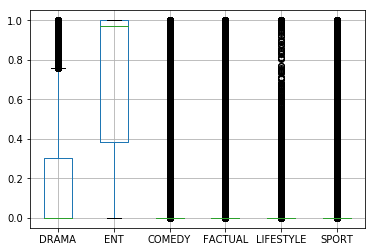

In [122]:
# Show boxplots of the highest means
boxplot = df_genre2.boxplot(column=['DRAMA', 'ENT', 'COMEDY', 'FACTUAL', 'LIFESTYLE', 'SPORT'])

In [233]:
#df_genre2.loc[:,'ENT'].plot.bar(stacked=True, figsize=(10,7))

In [43]:
## Pivot Subgenre data

# Remove duplicates
df_subgenre=df_subgenre.drop_duplicates(subset=None, keep='first', inplace=False)

# Pivot the programmes to show identicator values of 0 or 1 if they have watched a programme
df_subgenre2=df_subgenre.pivot_table(index='viewer_id',columns='sub_genre',values= 'subgenre_proportion_consumption').fillna(0)


In [66]:
df_subgenre2.head()

sub_genre,'MAKING OF' SHOWS,ACTION & ADVENTURE,ACTION AND ADVENTURE,ADULT ANIMATION,ALTERNATIVE COMEDY,ARTS DOCUMENTARY,AWARDS SHOWS,BASED ON A TRUE STORY,BIOGRAPHIES,BOXING,...,TRUE STORY,TV MOVIE,US COMEDY,US DRAMA,VARIETY,WAR,WAR FILM,WESTERN,WILDLIFE AND ENVIRONMENT,WRESTLING
viewer_id,,,,,,,,,,,,,,,,,,,,,
00001f83-95cb-4370-a1c8-f8c3cd0db845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00003f72-36f1-4b01-93a2-30a9ee254030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000076e0-dc41-432e-aa71-48ccf0d7bfe4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00008120-a8c1-4a56-936f-b69d94283556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000df48-056f-47f2-9bb3-970de65985c7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
df_subgenre2.describe(include = 'all')

sub_genre,'MAKING OF' SHOWS,ACTION & ADVENTURE,ACTION AND ADVENTURE,ADULT ANIMATION,ALTERNATIVE COMEDY,ARTS DOCUMENTARY,AWARDS SHOWS,BASED ON A TRUE STORY,BIOGRAPHIES,BOXING,...,TRUE STORY,TV MOVIE,US COMEDY,US DRAMA,VARIETY,WAR,WAR FILM,WESTERN,WILDLIFE AND ENVIRONMENT,WRESTLING
count,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,...,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,3.570360e+05,3.570360e+05,357036.000000,357036.000000
mean,0.000029,0.000040,0.000930,0.006298,0.001887,0.000032,0.000573,0.001086,0.000265,0.000357,...,0.000004,0.000484,0.006389,0.000199,0.004909,0.000569,2.453534e-07,9.802933e-09,0.001029,0.000153
std,0.002188,0.002246,0.021809,0.043793,0.016133,0.002815,0.011465,0.015766,0.006663,0.017440,...,0.001011,0.008741,0.044156,0.010508,0.033975,0.009505,1.376654e-04,5.857497e-06,0.025366,0.007363
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
max,0.333300,0.333300,1.000000,0.500000,0.500000,0.740200,0.500000,0.500000,1.000000,1.000000,...,0.455600,0.500000,1.000000,1.000000,1.000000,0.500000,8.220000e-02,3.500000e-03,1.000000,0.500000


In [7]:
# Count if anyone watched a genre for more than 20% of their time
df_subgenre2[df_subgenre2 >0.2].count().sort_values(ascending=False).head(20)

sub_genre
FACTUAL ENTERTAINMENT    251930
DATING SHOWS             222685
LONG-RUNNING DRAMA        45119
CRIME AND THRILLERS       33021
REAL LIVES                24126
TALENT SHOWS              11904
SCRIPTED FACTUAL           9945
CELEBRITIES                8450
PERIOD AND HISTORICAL      8206
SPORTS EVENT               7411
FAMILY ENTERTAINMENT       4194
US COMEDY                  3973
CYCLING                    3937
ADULT ANIMATION            3930
QUIZ AND GAME SHOWS        3838
FOOTBALL                   3690
CONTEMPORARY BRITISH       3676
DOCUMENTARY                3101
VARIETY                    2745
CHAT AND MAGAZINE          2742
dtype: int64

In [21]:
# Count if anyone watched a genre for more than 5% of their time
df_subgenre2[df_subgenre2 >0.05].count().sort_values(ascending=False).head(20)

sub_genre
FACTUAL ENTERTAINMENT    274623
DATING SHOWS             245784
REAL LIVES                73096
LONG-RUNNING DRAMA        60802
CRIME AND THRILLERS       56864
SCRIPTED FACTUAL          35974
TALENT SHOWS              32169
CELEBRITIES               28562
PERIOD AND HISTORICAL     19316
FAMILY ENTERTAINMENT      14737
QUIZ AND GAME SHOWS       13667
DOCUMENTARY               12589
CONTEMPORARY BRITISH      11848
SPORTS EVENT              10854
CHAT AND MAGAZINE          9914
SOCIAL DRAMA               9223
US COMEDY                  9088
ADULT ANIMATION            8978
VARIETY                    8836
FOOD AND DRINK             6419
dtype: int64

In [9]:
# Count if anyone watched a genre for more than 5% of their time
df_subgenre2[df_subgenre2 >0.9].count().sort_values(ascending=False).head(5)


sub_genre
LONG-RUNNING DRAMA       11800
CRIME AND THRILLERS       7139
TALENT SHOWS              2323
PERIOD AND HISTORICAL     1502
FOOTBALL                   828
dtype: int64

In [129]:
df_programmes.head()

,viewer_id,programme_title,programme_proportion_consumption
0,0003e717-b4f8-4136-b56e-05f8a5073578,Love Island: The Reunion,0.0786
1,0003e717-b4f8-4136-b56e-05f8a5073578,Love Island: Australia,0.0861
2,0003e717-b4f8-4136-b56e-05f8a5073578,Love Island,0.8351
4,00042b51-b442-4620-ab5b-9193358b3d1c,The Only Way is Essex,0.3110
5,00042b51-b442-4620-ab5b-9193358b3d1c,The X Factor,0.1624


In [33]:
import gc
gc.collect()
del df_genre
del df_subgenre
del boxplot

NameError: name 'boxplot' is not defined

In [44]:
## Pivot Programme data

# Remove duplicates
df_programmes=df_programmes.drop_duplicates(subset=None, keep='first', inplace=False)

# Pivot the programmes to show identicator values of 0 or 1 if they have watched a programme
df_programmes2=df_programmes.pivot_table(index='viewer_id',columns='programme_title',values= 'programme_proportion_consumption').fillna(0)


In [9]:
df_programmes2.describe(include = 'all')

programme_title,100 Year Old Driving School,100 Years Younger in 21 Days,1: Life on the Limit,2Awesome,2Awesome - Cheerleaders,5 Gold Rings,A Christmas Carol,A Christmas Chase: Celebrity Special,A Dangerous Man,A Mother's Son,...,Wycliffe,You VS. Chris & Kem,You're Only Young Twice,You've Been Framed!,Your Song,Yummy Mummies,Zoe Ball on...,easyJet: Inside The Cockpit,you've been t@gged,£10k Holiday Home
count,357036.000000,357036.000000,3.570360e+05,3.570360e+05,357036.000000,357036.000000,3.570360e+05,357036.000000,357036.0,357036.000000,...,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000,357036.000000
mean,0.000067,0.000185,8.707805e-07,3.285383e-07,0.000014,0.000128,3.649492e-07,0.000012,0.0,0.000009,...,0.000048,0.000585,0.000067,0.000080,0.000012,0.000061,0.000116,0.000289,0.000355,0.000347
std,0.004700,0.007764,3.530498e-04,1.018714e-04,0.002200,0.006285,1.897873e-04,0.001732,0.0,0.002397,...,0.004052,0.011364,0.005509,0.006411,0.002461,0.003937,0.007882,0.011638,0.014342,0.012182
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,2.013000e-01,5.240000e-02,0.657900,1.000000,1.119000e-01,0.797200,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
# Count if anyone watched a genre for more than 5% of their time
df_programmes2[df_programmes2 >0.05].count().sort_values(ascending=False).head(50)


programme_title
Love Island                               239052
Coronation Street                          54098
Emmerdale                                  33680
The Only Way is Essex                      33652
Love Island: Aftersun                      30715
Unforgotten                                27433
The X Factor                               25965
Love Island: Australia                     21659
Love Island: The Reunion                   17431
The Real Housewives of Cheshire            15968
Love Island: The Weekly Hot List           12729
The Jeremy Kyle Show                       10608
Family Guy                                  9993
Strangers                                   9438
Vanity Fair                                 9412
Britain's Got Talent                        9003
Vera                                        7364
I'm a Celebrity... Get Me Out of Here!      6606
Celebrity Juice                             6084
This Morning                                5495
Surv

In [13]:
# Count if anyone watched a genre for more than 20% of their time
df_programmes2[df_programmes2 >0.20].count().sort_values(ascending=False).head(10)


programme_title
Love Island                        223834
Coronation Street                   40066
Emmerdale                           23645
Unforgotten                         14869
The Only Way is Essex               14732
Love Island: Australia              13987
The X Factor                        11635
The Real Housewives of Cheshire      6075
The Jeremy Kyle Show                 5526
Family Guy                           4755
dtype: int64

In [14]:
# Count if anyone watched a genre for more than 50% of their time
df_programmes2[df_programmes2 >0.50].count().sort_values(ascending=False).head(10)


programme_title
Love Island                               190559
Coronation Street                          16197
Emmerdale                                   7846
Unforgotten                                 6653
Love Island: Australia                      5937
The Only Way is Essex                       5080
The X Factor                                4826
Tour de France                              2552
The Jeremy Kyle Show                        2297
I'm a Celebrity... Get Me Out of Here!      2176
dtype: int64

In [15]:
# Count if anyone watched a genre for more than 90% of their time
df_programmes2[df_programmes2 >0.9].count().sort_values(ascending=False).head(10)


programme_title
Love Island                               118948
Coronation Street                           5889
Unforgotten                                 3321
Emmerdale                                   2628
The X Factor                                2416
The Only Way is Essex                       2324
Tour de France                              1742
Love Island: Australia                      1587
World Cup                                   1379
I'm a Celebrity... Get Me Out of Here!      1300
dtype: int64

# Missing data check

In [68]:
# Check how much missing data
df_programmes2.isnull().values.any()


False

In [69]:
# Check how much missing data
df_genre2.isnull().values.any()

False

In [119]:
# Check how much missing data
df_subgenre2.isnull().values.any()

False

In [ ]:
# Check how much missing data
df_demographics.isna().sum()

In [39]:
len(df_demographics)

399298

In [45]:
# Remove ages that are missing and if ages are more than 90 (This has removed 35,098)

df_demographics = df_demographics[df_demographics.age <91]
df_demographics= df_demographics[pd.notnull(df_demographics['age'])]

In [92]:
# Replace age value with average age of HUB  which is 38 (16 -100)
#df_demographics['age']=df_demographics['age'].replace(np.nan, 38)
# Replace missing genders with female
#df_demographics['gender']=df_demographics['gender'].replace(np.nan, 'F')


In [10]:
len(df_demographics)

364200

In [11]:
# Not going to use experian as more than half are missing
df_demographics.isna().sum()

viewer_id                    0
age                          0
gender                       0
abc1_flag                    0
h_lifestage             231233
pc_mosaic_uk_6_type     231233
pc_mosaic_uk_6_group    231233
dtype: int64

In [44]:
# Check how much missing data
df_programmes.isna().sum()

viewer_id                               0
programme_title                     15736
programme_proportion_consumption        0
dtype: int64

In [46]:
# Rename the abc1 flag to show abc1 and c2de

df_demographics['abc1_flag']=df_demographics['abc1_flag'].replace('1', 'abc1')
df_demographics['abc1_flag']=df_demographics['abc1_flag'].replace('0', 'c2de')

In [46]:
df_demographics.head()

,viewer_id,age,gender,abc1_flag,h_lifestage,pc_mosaic_uk_6_type,pc_mosaic_uk_6_group
0,00720ddf-a9d1-492f-bf62-ea307618adba,20.0,M,c2de,None,None,None
1,00ce9550-31c7-49ed-ac39-836be6305535,37.0,F,abc1,None,None,None
2,0135def7-3e41-4ab0-84bc-1f862061b38d,41.0,F,abc1,None,None,None
3,01d7a5d7-183a-4909-bb63-1ab12d6a22fd,70.0,M,abc1,None,None,None
4,01f124bd-521d-4318-bcaf-957ed7484355,59.0,M,c2de,None,None,None


In [47]:
# Convert to dummy variables
df_demographics_dummies=pd.concat([df_demographics, pd.get_dummies(df_demographics['gender']).astype('int32'),
                                    pd.get_dummies(df_demographics['abc1_flag']).astype('int32')],axis=1)
                                    ##pd.get_dummies(df_demographics['h_lifestage']).astype('int32'),
                                    ##pd.get_dummies(df_demographics['pc_mosaic_uk_6_type']).astype('int32'),
                                    ##pd.get_dummies(df_demographics['pc_mosaic_uk_6_group']).astype('int32')],axis=1)

In [56]:
df_demographics_dummies.head()

,viewer_id,age,gender,abc1_flag,h_lifestage,pc_mosaic_uk_6_type,pc_mosaic_uk_6_group,F,M,X,abc1,c2de
0,00720ddf-a9d1-492f-bf62-ea307618adba,20.0,M,c2de,None,None,None,0,1,0,0,1
1,00ce9550-31c7-49ed-ac39-836be6305535,37.0,F,abc1,None,None,None,1,0,0,1,0
2,0135def7-3e41-4ab0-84bc-1f862061b38d,41.0,F,abc1,None,None,None,1,0,0,1,0
3,01d7a5d7-183a-4909-bb63-1ab12d6a22fd,70.0,M,abc1,None,None,None,0,1,0,1,0
4,01f124bd-521d-4318-bcaf-957ed7484355,59.0,M,c2de,None,None,None,0,1,0,0,1


In [49]:
#df_demographics.groupby('age').count()
df_demographics_dummies=df_demographics_dummies.drop(['gender', 'abc1_flag','h_lifestage', 'pc_mosaic_uk_6_type', 'pc_mosaic_uk_6_group'],axis=1)

In [250]:
# Rename columns

#df_demographics_dummies=df_demographics_dummies.rename(columns = {'0':'c2de_FLAG'})
#df_demographics_dummies=df_demographics_dummies.rename(columns = {'1':'abc1_FLAG'})

In [50]:
df_demographics_dummies.columns

Index(['viewer_id', 'age', 'F', 'M', 'X', 'abc1', 'c2de'], dtype='object')

In [51]:
# Biggest age for Hub+ is 23
df_demographics_dummies[['viewer_id','age']].groupby('age').count().head(60)


,viewer_id
age,
16.0,1154
17.0,4198
18.0,11086
19.0,14286
20.0,17048
21.0,17963
22.0,18211
23.0,18721
24.0,14726


In [52]:
print('Median:') 
print(df_demographics_dummies[['age']].median())
print('Mean:') 
print(df_demographics_dummies[['age']].mean())

Median:
age    30.0
dtype: float64
Mean:
age    34.399725
dtype: float64


In [256]:
df_demographics_dummies.head()

,viewer_id,age,gender,abc1_flag,h_lifestage,pc_mosaic_uk_6_type,pc_mosaic_uk_6_group,F,M,X,...,F,G,H,I,J,K,L,M,N,O
0,00104551-6dba-4333-9857-3f776836636c,64.0,M,1,09,24.0,F,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,00104551-6dba-4333-9857-3f776836636c,64.0,M,1,09,24.0,F,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,00104551-6dba-4333-9857-3f776836636c,64.0,M,1,09,24.0,F,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,00104551-6dba-4333-9857-3f776836636c,64.0,M,1,09,24.0,F,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,00104551-6dba-4333-9857-3f776836636c,64.0,M,1,09,24.0,F,0,1,0,...,1,0,0,0,0,0,0,0,0,0


# Bivariate EDA

In [ ]:
# Age by subgenres

In [96]:
len(df_programmes2)

333987

In [48]:
# Join viewer data and demographics
from functools import reduce

df_demo_genre = reduce(lambda left,right: pd.merge(left,right,on='viewer_id'), 
                  [df_demographics_dummies,
                   df_weekdayweekend,
                   df_activeness,
                   df_genre2, 
                   df_subgenre2,
                   df_programmes2,
                  df_avg_consumption])

In [19]:
df_demo_genre.head()

,viewer_id,age,gender,abc1_flag,h_lifestage,pc_mosaic_uk_6_type,pc_mosaic_uk_6_group,F,M,X,...,You VS. Chris & Kem,You're Only Young Twice,You've Been Framed!,Your Song,Yummy Mummies,Zoe Ball on...,easyJet: Inside The Cockpit,you've been t@gged,£10k Holiday Home,monthly_consumption
0,1a3af716-74b5-4efe-b3d1-da66b978cb2a,56.0,F,abc1,09,57,N,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.7037081944
1,4bc0d2c7-51ba-4aa3-804c-dccee1f557d1,26.0,M,abc1,09,10,C,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0662200000
2,6f8e716d-d2f8-4c03-a677-5b080f570b98,28.0,F,abc1,11,14,D,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.5035417592
3,79616ca9-372b-4681-83dd-5448392c98a7,61.0,F,abc1,None,None,None,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2572305555
4,83ab7d25-8b17-453f-87d6-b26c0aa0fb46,60.0,F,c2de,13,64,O,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2066900925


In [66]:
len(df_demo_genre)

323453

In [67]:
list(df_demo_genre.columns)

['viewer_id',
 'age',
 'gender',
 'abc1_flag',
 'h_lifestage',
 'pc_mosaic_uk_6_type',
 'pc_mosaic_uk_6_group',
 'F',
 'M',
 'X',
 'abc1',
 'c2de',
 'weekday_consumption',
 'weekend_consumption',
 'total_consumption',
 'weekday_proportion',
 'weekend_proportion',
 'm_active_days',
 'ARTS',
 'CHILDREN',
 'COMEDY_x',
 'DRAMA_x',
 'ENT',
 'FACTUAL',
 'FILM',
 'LIFESTYLE',
 'NEWS_x',
 'RELIGION',
 'SPORT_x',
 "'MAKING OF' SHOWS",
 'ACTION & ADVENTURE',
 'ACTION AND ADVENTURE',
 'ADULT ANIMATION',
 'ALTERNATIVE COMEDY',
 'ARTS DOCUMENTARY',
 'AWARDS SHOWS',
 'BASED ON A TRUE STORY',
 'BIOGRAPHIES',
 'BOXING',
 'BUSINESS AND CONSUMER',
 'CELEBRITIES',
 'CELEBRITY',
 'CHAT AND MAGAZINE',
 "CHILDREN'S ACTION AND ADVENTURE",
 "CHILDREN'S ANIMATION",
 "CHILDREN'S COMEDY",
 "CHILDREN'S DRAMA",
 "CHILDREN'S ENTERTAINMENT",
 "CHILDREN'S FACTUAL",
 "CHILDREN'S FILM",
 "CHILDREN'S QUIZ AND GAME SHOWS",
 "CHILDREN'S SCIENCE FICTION AND FANTASY",
 'CLASSIC COMEDY',
 'CLIP SHOWS',
 'COMEDY_y',
 'COMEDY 

(0, 110)

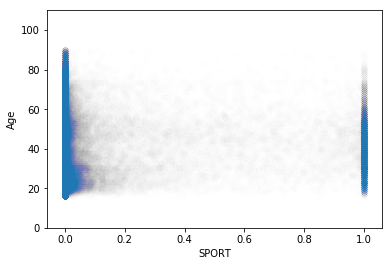

In [49]:
plt.scatter(df_demo_genre['SPORT_x'],(df_demo_genre['age']),alpha=0.003)
plt.xlabel("SPORT")
plt.ylabel("Age")
plt.ylim((0,110))

(0, 110)

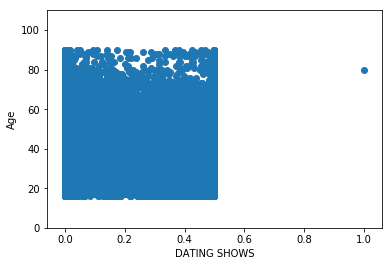

In [50]:
plt.scatter(df_demo_genre['DATING SHOWS'],(df_demo_genre['age']))
plt.xlabel("DATING SHOWS")
plt.ylabel("Age")
plt.ylim((0,110))

(0, 110)

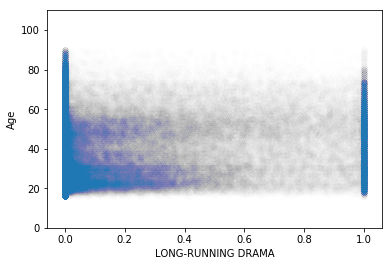

In [51]:
plt.scatter(df_demo_genre['LONG-RUNNING DRAMA'],(df_demo_genre['age']),alpha=0.002)
plt.xlabel("LONG-RUNNING DRAMA")
plt.ylabel("Age")
plt.ylim((0,110))

(0, 110)

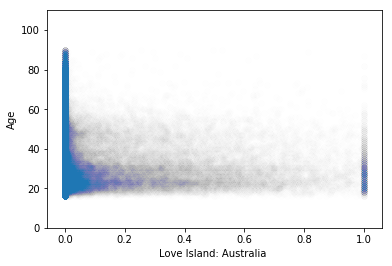

In [52]:
plt.scatter(df_demo_genre['Love Island: Australia'],(df_demo_genre['age']),alpha=0.002)
plt.xlabel("Love Island: Australia ")
plt.ylabel("Age")
plt.ylim((0,110))

In [ ]:
plt.scatter(df_demo_genre['Coronation Street'],(df_demo_genre['age']),alpha=0.002)
plt.xlabel("Coronation Street")
plt.ylabel("Age")
plt.ylim((0,110))

(0, 110)

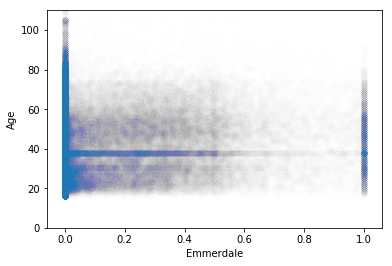

In [46]:
# Emmerdale is showing some people only watch 100% emmerdale or some people watch it less than 50% as their viewing
# Hence they watch Emmerdale in combination with other programmes.
plt.scatter(df_demo_genre['Emmerdale'],(df_demo_genre['age']),alpha=0.002)
plt.xlabel("Emmerdale")
plt.ylabel("Age")
plt.ylim((0,110))

(0, 110)

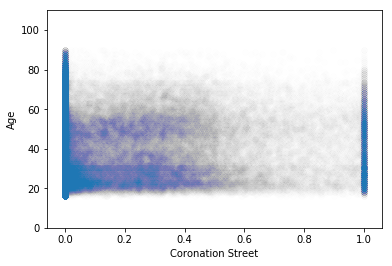

In [53]:
plt.scatter(df_demo_genre['Coronation Street'],(df_demo_genre['age']),alpha=0.002)
plt.xlabel("Coronation Street")
plt.ylabel("Age")
plt.ylim((0,110))

(0, 110)

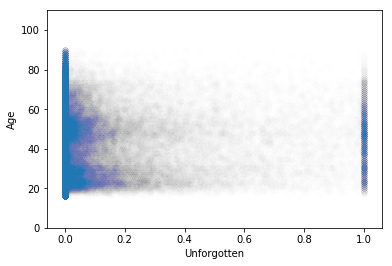

In [54]:
# Some people sign up for just Unforgotten, but then majoirt watch a combination of programmes
plt.scatter(df_demo_genre['Unforgotten'],(df_demo_genre['age']),alpha=0.002)
plt.xlabel("Unforgotten")
plt.ylabel("Age")
plt.ylim((0,110))

In [60]:
df_demographics.head()

,viewer_id,age,gender,abc1_flag,h_lifestage,pc_mosaic_uk_6_type,pc_mosaic_uk_6_group
0,003e0f29-4fef-46bb-a8dc-0457f9743e6f,42.0,M,0,NaN,NaN,NaN
1,00adf963-3d8f-43c0-965b-d5f17e0d9c3f,82.0,F,1,NaN,NaN,NaN
2,00e7da45-ad09-4b2a-965d-fc2ef308dda6,36.0,M,0,NaN,NaN,NaN
3,013a72f7-bdcf-46a8-865e-80fd9bfd64f4,55.0,F,1,NaN,NaN,NaN
4,01753841-4808-489a-965a-e23c2939b1c2,32.0,F,1,05,62.0,O


In [ ]:
len(df_demo_genre)

In [40]:
df_demo_genre.to_csv('H:/Hub+_Segmentation/tesing.csv')

# Remove Outliers

In [ ]:
# Do this at some point!

# Testing reduced dataframe

In [56]:
df_demo_genre.count()

viewer_id                                    323453
age                                          323453
gender                                       323453
abc1_flag                                    323453
h_lifestage                                  116140
pc_mosaic_uk_6_type                          116140
pc_mosaic_uk_6_group                         116140
F                                            323453
M                                            323453
X                                            323453
abc1                                         323453
c2de                                         323453
weekday_consumption                          323453
weekend_consumption                          323453
total_consumption                            323453
weekday_proportion                           323453
weekend_proportion                           323453
m_active_days                                323453
ARTS                                         323453
CHILDREN    

In [61]:
# MONDAY TASK # We need to reduce the dimensions to make them useable for targeting ##
# We can always profile on top to find nuggets of information #
# What happens if I only put in the genres, subgenres, programmes with the highest volumes

#np.set_printoptions(threshold=sys.maxsize)
import sys

pd.options.display.max_rows
#np.set_printoptions(threshold='nan')
df_demo_genre[df_demo_genre >0.01].count().sort_values(ascending=False).head(65)

#Filter by large volumes only

monthly_consumption                  323453
weekend_proportion                   323453
age                                  323453
gender                               323453
abc1_flag                            323453
weekday_consumption                  323453
weekend_consumption                  323453
total_consumption                    323453
weekday_proportion                   323453
viewer_id                            323453
ENT                                  277465
m_active_days                        269768
FACTUAL ENTERTAINMENT                256832
DATING SHOWS                         229197
F                                    228765
Love Island                          221253
c2de                                 175619
abc1                                 147834
DRAMA_x                              116527
h_lifestage                          116140
pc_mosaic_uk_6_type                  116140
pc_mosaic_uk_6_group                 116140
REAL LIVES                      

In [48]:
list(df_demo_genre.columns)

['viewer_id',
 'age',
 'gender',
 'abc1_flag',
 'h_lifestage',
 'pc_mosaic_uk_6_type',
 'pc_mosaic_uk_6_group',
 'F',
 'M',
 'X',
 0,
 1,
 'ARTS',
 'CHILDREN',
 'COMEDY_x',
 'DRAMA_x',
 'ENT',
 'FACTUAL',
 'FILM',
 'LIFESTYLE',
 'NEWS_x',
 'RELIGION',
 'SPORT_x',
 "'MAKING OF' SHOWS",
 'ACTION & ADVENTURE',
 'ACTION AND ADVENTURE',
 'ADULT ANIMATION',
 'ALTERNATIVE COMEDY',
 'ARTS DOCUMENTARY',
 'AWARDS SHOWS',
 'BASED ON A TRUE STORY',
 'BIOGRAPHIES',
 'BOXING',
 'BUSINESS AND CONSUMER',
 'CELEBRITIES',
 'CELEBRITY',
 'CHAT AND MAGAZINE',
 "CHILDREN'S ACTION AND ADVENTURE",
 "CHILDREN'S ANIMATION",
 "CHILDREN'S COMEDY",
 "CHILDREN'S DRAMA",
 "CHILDREN'S ENTERTAINMENT",
 "CHILDREN'S FACTUAL",
 "CHILDREN'S FILM",
 "CHILDREN'S QUIZ AND GAME SHOWS",
 "CHILDREN'S SCIENCE FICTION AND FANTASY",
 'CLASSIC COMEDY',
 'CLIP SHOWS',
 'COMEDY_y',
 'COMEDY DRAMA',
 'CONTEMPORARY BRITISH',
 'CRIME AND THRILLER',
 'CRIME AND THRILLERS',
 'CRIME DOCUMENTARY',
 'CURRENT AFFAIRS',
 'CYCLING',
 'DARTS',


In [66]:
df_demo_genre_reduced=df_demo_genre[['age',
                                     'F',
                                     'M',
                                     'X',
                                     "c2de",
                                     "abc1",
                                     "monthly_consumption",
                                     'weekday_consumption',
                                     'weekend_consumption',
                                     'm_active_days',
                                    'ENT',
                                    'DRAMA_x',
                                    'SPORT_x',
                                    'FACTUAL',
                                    'COMEDY_x',
                                     "FACTUAL ENTERTAINMENT",
"DATING SHOWS",
"LONG-RUNNING DRAMA",
"CRIME AND THRILLERS",
"REAL LIVES",
"TALENT SHOWS",
"SCRIPTED FACTUAL",
"CELEBRITIES",
"PERIOD AND HISTORICAL",
"SPORTS EVENT",
"FAMILY ENTERTAINMENT",
"US COMEDY",
"CYCLING",
"ADULT ANIMATION",
"QUIZ AND GAME SHOWS",
"FOOTBALL",
"CONTEMPORARY BRITISH",
"DOCUMENTARY",
"VARIETY",
"CHAT AND MAGAZINE",
"FOOD AND DRINK",
"SOCIAL DRAMA",
"Love Island",
"Coronation Street",
"Emmerdale",
"The Only Way is Essex",
"Love Island: Aftersun",
"Unforgotten",
"The X Factor",
"Love Island: Australia",
"Love Island: The Reunion",
"The Real Housewives of Cheshire",
"The Jeremy Kyle Show",
"Family Guy",
"Tour de France",
"I'm a Celebrity... Get Me Out of Here!",
"World Cup",
"Love Island: The Weekly Hot List",
"Strangers",
"Vanity Fair",
"Britain's Got Talent",
"Vera",
"Celebrity Juice",
"This Morning",
"Survival Of The Fittest",
"Marcella",
"Liar",
"Ibiza Weekender",
"Long Lost Family",
"American Dad!",
"The Voice Kids",
"Endeavour",
"Loose Women",
"Sam & Billie Faiers: The Mummy Diaries",
"Victoria",
"Innocent",
"Benidorm",
"The Chase",
"The Voice",
"Take Me Out",
"Absolutely Ascot",
"Dinner Date",
"The Bletchley Circle",
"Our Shirley Valentine Summer",
"Broadchurch",
"The Durrells",
"Gemma Collins Diva Espana",
"Midsomer Murders",
"Ferne McCann: First Time Mum",
"Cold Feet",
"Lewis",
"Scott & Bailey"]]

In [153]:
df_demo_genre_reduced=df_demo_genre[["monthly_consumption",
"age",
"ENT",
"m_active_days",
"FACTUAL ENTERTAINMENT",
"DATING SHOWS",
"F",
"Love Island",
"abc1",
"DRAMA_x",
"REAL LIVES",
"FACTUAL",
"CRIME AND THRILLERS",
"LONG-RUNNING DRAMA",
"Coronation Street",
"Love Island: Aftersun",
"CELEBRITIES",
"TALENT SHOWS",
"SCRIPTED FACTUAL",
"The Only Way is Essex",
"Emmerdale",
"The X Factor",
"QUIZ AND GAME SHOWS",
"Unforgotten",
"COMEDY_x",
"DOCUMENTARY",
"FAMILY ENTERTAINMENT",
"Love Island: Australia",
"SPORT_x"]]


In [207]:
df_demo_genre_reduced=df_demo_genre[["age",
"LONG-RUNNING DRAMA",
 "DATING SHOWS",                                    
"REAL LIVES",                                   
"COMEDY_x",                                
 "SPORT_x"]]                                               

In [ ]:
df_demo_genre_reduced.head()

# Principle Component Analysis

In [208]:
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, NMF
from sklearn.preprocessing import StandardScaler

In [209]:
df_demo_genre_reduced.head()

,age,LONG-RUNNING DRAMA,DATING SHOWS,REAL LIVES,COMEDY_x,SPORT_x
0,24.0,0.3260,0.1308,0.1074,0.0074,0.0
1,53.0,0.1516,0.0028,0.0000,0.0178,0.0
2,18.0,0.5871,0.0025,0.0982,0.0000,0.0
3,41.0,0.0000,0.0000,0.0419,0.0000,0.0
4,38.0,0.1534,0.0949,0.2139,0.0000,0.0


In [210]:
df_demo_genre_reduced.dtypes

age                   float64
LONG-RUNNING DRAMA    float64
DATING SHOWS          float64
REAL LIVES            float64
COMEDY_x              float64
SPORT_x               float64
dtype: object

In [157]:
df_demo_genre_reduced["monthly_consumption"] = df_demo_genre_reduced.monthly_consumption.convert_objects(convert_numeric=True)
#df_demo_genre_reduced["weekend_proportion"] = df_demo_genre_reduced.weekend_proportion.convert_objects(convert_numeric=True)
#df_demo_genre_reduced["weekday_consumption"] = df_demo_genre_reduced.weekday_consumption.convert_objects(convert_numeric=True)
#df_demo_genre_reduced["weekend_consumption"] = df_demo_genre_reduced.weekend_consumption.convert_objects(convert_numeric=True)
#df_demo_genre_reduced["weekday_proportion"] = df_demo_genre_reduced.weekday_proportion.convert_objects(convert_numeric=True)

C:\Users\annibald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.
C:\Users\annibald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [132]:
#df_demo_genre=df_demo_genre.drop(['viewer_id'],axis=1)

In [211]:
scaler = StandardScaler()
viewing_scaled = scaler.fit_transform(df_demo_genre_reduced)

In [212]:
pca = PCA()
viewing_reduced = pca.fit_transform(viewing_scaled)

In [216]:
# Takes only the first 50 components by transforming to dataframe
viewing_reduced=pd.DataFrame(viewing_reduced).iloc[:,0:5]


viewing_reduced.head()

,0,1,2,3
0,0.702575,0.663742,-0.654008,-0.044146
1,1.605771,-0.464572,-0.186812,0.199633
2,1.368497,0.455141,-1.193380,0.163451
3,0.936193,0.252410,0.086797,-0.164862
4,1.195400,1.644267,-0.343582,-0.697734


In [215]:
# Transforms back to array
viewing_reduced=viewing_reduced.values

In [196]:
print(viewing_reduced)

[[ 0.60336962  1.10938971  0.7116763  -0.8152436 ]
 [ 1.58401048  0.49967012 -0.97550543 -0.05697262]
 [ 0.75134194  1.37889027  1.27576765 -1.07425705]
 ...
 [ 1.39202937  0.25724101 -1.47093451 -0.17220424]
 [ 1.10697747  0.34089218 -1.19540273 -0.45398427]
 [-1.42102613  0.53447727  0.05692898  0.29827162]]


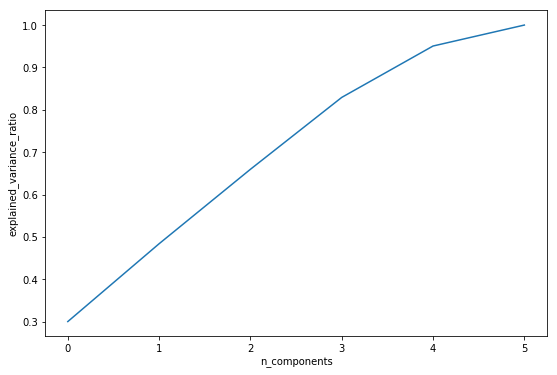

In [213]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(pca.explained_variance_ratio_.cumsum())
ax.set_xlabel('n_components')
ax.set_ylabel('explained_variance_ratio');

In [217]:
loadings_array = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings = pd.DataFrame(loadings_array.T)
loadings.columns = df_demo_genre_reduced.columns
loadings.index = loadings.index+1
loadings.head(10).transpose()

,1,2,3,4,5,6
age,0.705249,-0.236006,-0.024740,-0.063634,0.641655,0.174771
LONG-RUNNING DRAMA,0.605696,-0.274947,-0.511636,0.170180,-0.473959,0.205353
DATING SHOWS,-0.893523,-0.184176,-0.096107,-0.018357,0.088661,0.387639
REAL LIVES,0.247301,0.879420,-0.029672,-0.345299,-0.058188,0.204859
COMEDY_x,0.121908,0.253365,0.420333,0.854344,-0.000812,0.119849
SPORT_x,0.254121,-0.314640,0.777446,-0.367386,-0.282314,0.131644


In [31]:
loadings.iloc[0:25,:].to_csv('H:/Hub+_Segmentation/loadings.csv')

## Biclusering Testing

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_checkerboard
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score


# Modelling 

In [218]:
principalDf = pd.DataFrame(data = viewing_reduced)

In [144]:
#principalDf.to_csv('Z:/Automated Files/Annie/Hub+/principalDf.csv')

In [223]:
# Work out optimal number of clusters

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(principalDf)
    Sum_of_squared_distances.append(km.inertia_)

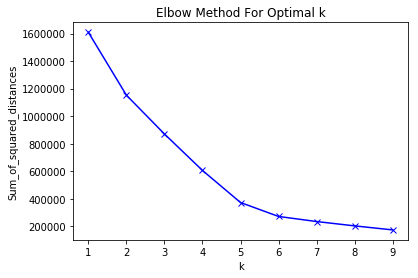

In [224]:
# Plot the elbow curve

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [67]:
#principalDf.to_csv('H:/Hub+_Segmentation/PCA_DF.csv')

In [242]:
from sklearn.cluster import KMeans

# Number of clusters
kmeans = KMeans(n_clusters=3)
# Fitting the input data
kmeans = kmeans.fit(principalDf)
# Getting the cluster labels
labels = kmeans.predict(principalDf)
# Centroid values
centroids = kmeans.cluster_centers_

In [243]:
# Comparing with scikit-learn centroids
print(centroids) # From sci-kit learn

[[-9.11960573e-01 -1.48667711e-01 -5.58111577e-02 -1.11630931e-04]
 [ 1.46199377e+00  4.02174719e-01 -2.39780783e-01  1.58330266e-01]
 [ 2.06806915e+00 -2.00960985e+00  4.84257503e+00 -2.26500259e+00]]


In [226]:
# Glue back to originaal data
df_demo_genre_reduced['clusters'] = labels


C:\Users\annibald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [227]:
# Check what the size of each cluster is
counts = np.bincount(labels[labels>=0])

print(counts)

[206326   7948  72937   4981  31261]


In [228]:
df_demo_genre_reduced.head()

,age,LONG-RUNNING DRAMA,DATING SHOWS,REAL LIVES,COMEDY_x,SPORT_x,clusters
0,24.0,0.3260,0.1308,0.1074,0.0074,0.0,2
1,53.0,0.1516,0.0028,0.0000,0.0178,0.0,2
2,18.0,0.5871,0.0025,0.0982,0.0000,0.0,2
3,41.0,0.0000,0.0000,0.0419,0.0000,0.0,2
4,38.0,0.1534,0.0949,0.2139,0.0000,0.0,4


In [244]:
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score

X=df_demo_genre_reduced.drop(['clusters'],axis=1).values

y=df_demo_genre_reduced['clusters'].values

# Testing on using two clusters
silhouette_score(X, y, sample_size=13000, random_state=11)

0.07087945148284447

In [235]:
len(y)

323453

ValueError: too many values to unpack (expected 2)

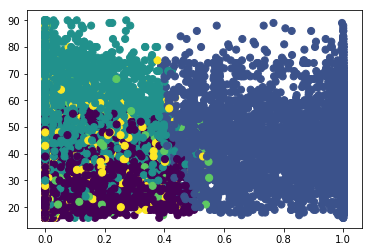

In [245]:
# Plot the clusters

import numpy as np
import matplotlib.pyplot as plt

x=df_demo_genre_reduced['SPORT_x'].values
y=df_demo_genre_reduced['age'].values
Cluster = df_demo_genre_reduced['clusters'].values

centers = centroids 

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y,c=Cluster,s=50)
for i,j in centers:
    ax.scatter(i,j,s=50,c='red',marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)

fig.show()






In [230]:
# Look at the clusters on the data
df_demo_genre_reduced.to_csv("H:/Hub+_Segmentation/cluster_simple_subgenre.csv")

In [ ]:
principalDf=read_csv('Z:/Automated Files/Annie/Hub+/principalDf.csv')

In [52]:
df_demo_genre_reduced.head()

,age,F,M,X,c2de,abc1,monthly_consumption,weekday_consumption,weekend_consumption,m_active_days,...,Our Shirley Valentine Summer,Broadchurch,The Durrells,Gemma Collins Diva Espana,Midsomer Murders,Ferne McCann: First Time Mum,Cold Feet,Lewis,Scott & Bailey,clusters
0,30.0,1,0,0,0,1,9.7562874305,32.1714766666,6.8536730555,6,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0
1,49.0,1,0,0,0,1,15.8460527037,140.3133894444,87.1331627777,10,...,0.0,0.0,0.0,0.0,0.0705,0.0,0.0,0.1082,0.0,7
2,35.0,1,0,0,0,1,44.7847929166,51.0452383333,32.2761313888,18,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,4
3,53.0,0,1,0,1,0,8.7027962500,14.1534391666,2.4866180555,6,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0
4,30.0,1,0,0,1,0,14.7529490277,19.8015825000,9.7043155555,17,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,1


In [ ]:
 # Read in data

In [55]:
# Double check clusters are distinct enough

from sklearn.metrics import silhouette_samples, silhouette_score

X=df_demo_genre_reduced.drop(['clusters'],axis=1).values

y=df_demo_genre_reduced['clusters'].values

silhouette_score(X, y, metric='euclidean', sample_size=None, random_state=None)



MemoryError: 

MemoryError: 

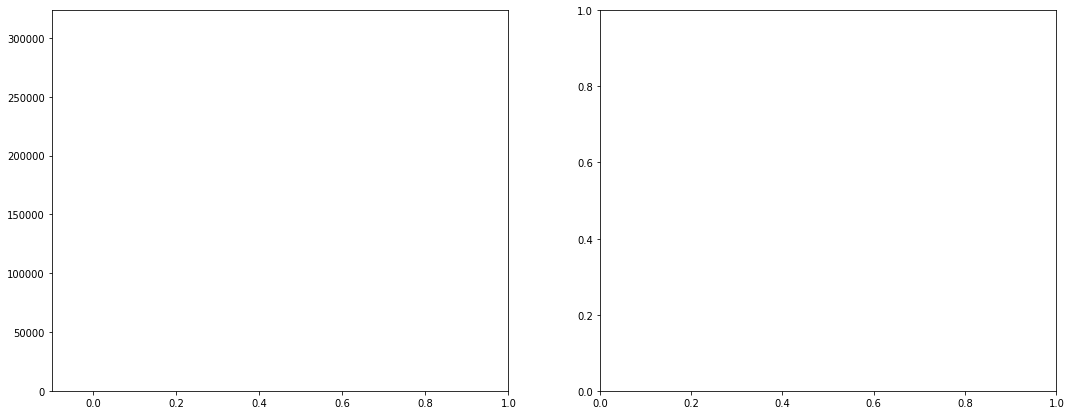

In [34]:
# Double check clusters are different enough

from __future__ import print_function

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [6,7,8]

X=principalDf.values


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')


In [90]:
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1) 

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.56376469026194
For n_clusters = 6 The average silhouette_score is : 0.4504666294372765
For n_clusters = 7 The average silhouette_score is : 0.39092211029930857
For n_clusters = 8 The average silhouette_score is : 0.33148538996489124


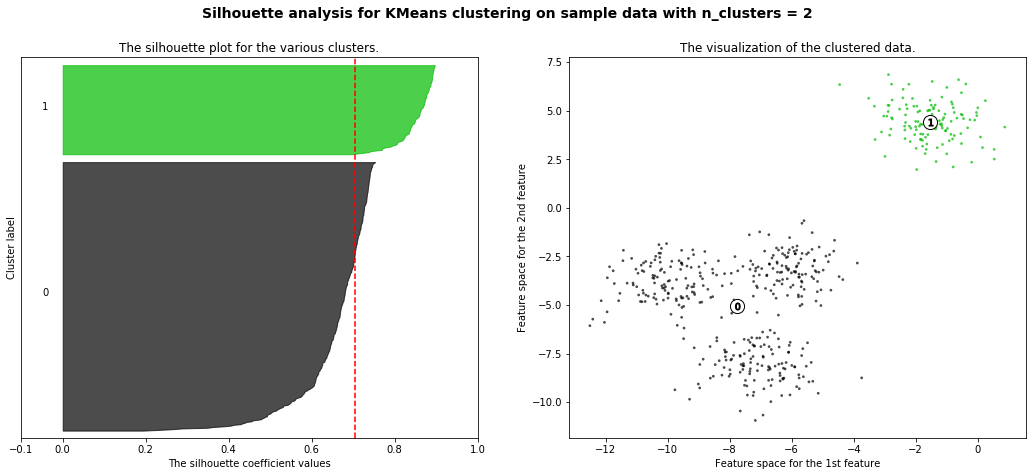

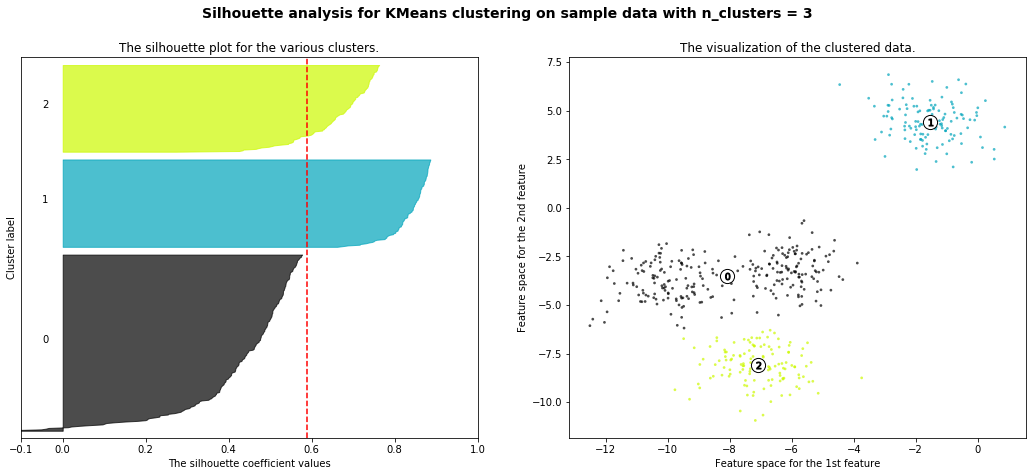

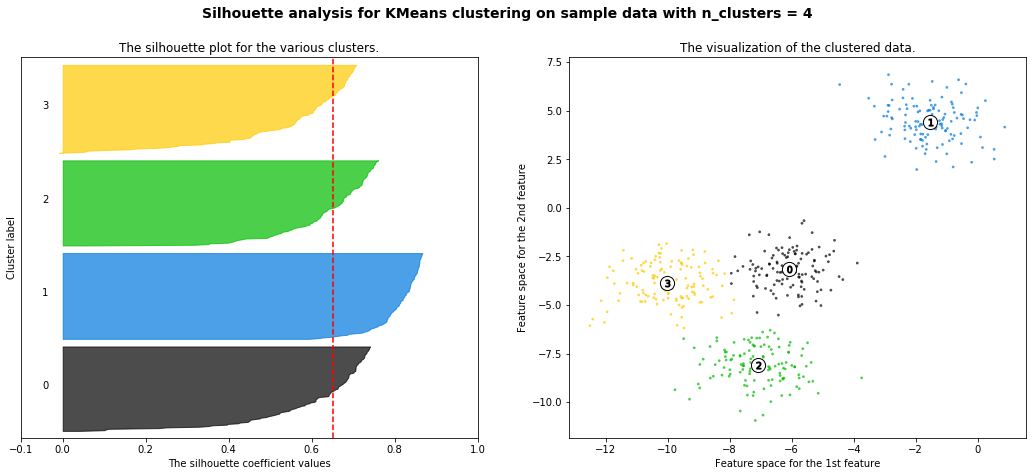

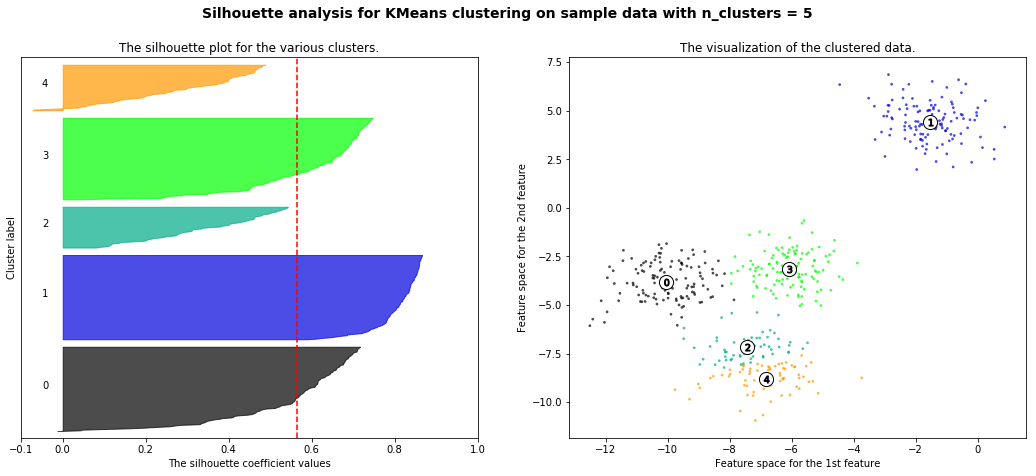

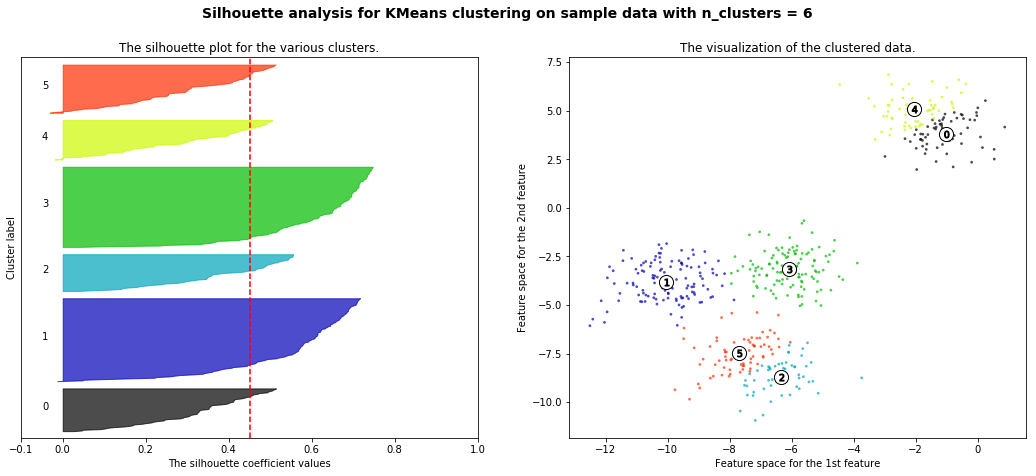

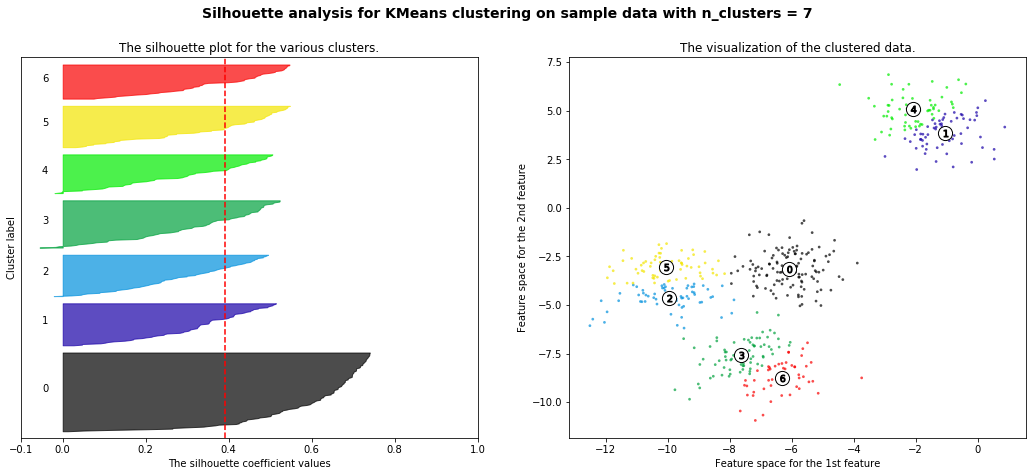

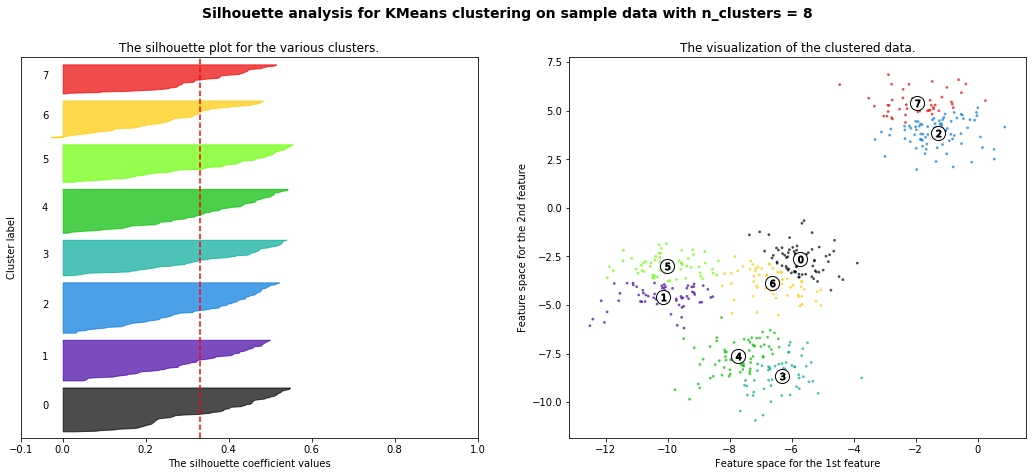

In [89]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6,7,8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

# DB Scan Modelling

In [34]:
from sklearn.cluster import DBSCAN

dbsc = DBSCAN(eps = .75, min_samples = 1000).fit(principalDf)

In [35]:
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True